In [1]:
import sys
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append("..")
from utils.search_rainfalls import search_rainfalls
from utils.time_series_utils import get_time_series_df, get_compare_by_time_df, check_abnormally_stable_value_station, check_extreme_value_station

sys.path.append("../../")
from common.utils import timestep_csv_names

In [2]:
df = search_rainfalls()
df.head()

,index,date,start_time,peak_time,end_time,duration minutes,max_rainfall
0,42,2019-06-24,16-0,18-40,19-50,230,98.0
1,56,2019-07-12,7-50,8-40,9-50,120,94.0
2,279,2020-08-01,3-40,5-0,7-10,210,88.0
3,338,2020-10-12,6-10,8-10,9-40,210,82.0
4,243,2020-07-27,10-50,12-20,13-40,170,80.0


In [3]:
strong_rainfalls = df.loc[df["max_rainfall"] > 40]
print(len(strong_rainfalls))
strong_rainfalls["date"].value_counts()[:10]

70


2020-10-24    2
2019-06-16    2
2020-08-19    2
2019-04-12    1
2019-05-26    1
2020-05-15    1
2020-04-18    1
2020-05-25    1
2019-07-14    1
2019-06-24    1
Name: date, dtype: int64

In [4]:
import pandas as pd


def convert_time_from_int(int_time: int) -> str:
    str_time = str(int_time)
    return str_time[:-2] + ":" + str_time[-2:]


def reset_time_from_str(x: str, str_time_series: list) -> str:
    center_idx = len(str_time_series) // 2
    time_idx = str_time_series.index(x)
    # if time_idx > center_idx:
    #     time = f"t+{10 * (time_idx - center_idx)}"
    # elif time_idx < center_idx:
    #     time = f"t-{10 * (center_idx - time_idx)}"
    # else:
    #     time = 0
    return 10 * (time_idx - center_idx)

_timestep_csv_names = timestep_csv_names(delta=10)
target_data = {}
for idx in strong_rainfalls.index:
    date = strong_rainfalls.loc[idx, "date"]
    peak_time = strong_rainfalls.loc[idx, "peak_time"]
    peak_time_idx = _timestep_csv_names.index(f"{peak_time}.csv")
    # 2 hours before and after of peak_time
    start_idx, end_idx = peak_time_idx - 18, peak_time_idx + 18
    if start_idx < 0 or end_idx > len(_timestep_csv_names) - 1:
        print(f"{date} is skipped. (start: {start_idx}, end: {end_idx})")
        continue
    target_data[date] = {"start_time": _timestep_csv_names[start_idx].replace(".csv", ""), "end_time": _timestep_csv_names[end_idx].replace(".csv", "")}


data_df = pd.DataFrame(columns=["Time", "ParamName", "Value", "Station_Name", "date"])
for date in target_data.keys():
    year, month, day = date.split("-")
    time_series_df = get_time_series_df(
        one_day_data_dir_path="../../../data/one_day_data",
        year=year,
        month=month,
        date=day,
        start_time=target_data[date]["start_time"],
        end_time=target_data[date]["end_time"],
    )
    compare_df = get_compare_by_time_df(time_series_df, set_zero_start=True, scaling_method="both")
    # Reset Time
    unique_times = compare_df["Time"].unique()
    sorted_unique_times = sorted([int(t.replace(":", "")) for t in unique_times])
    sorted_unique_times = [convert_time_from_int(t) for t in sorted_unique_times]
    compare_df["Time"] = compare_df["Time"].apply(reset_time_from_str, args=(sorted_unique_times,))
    # Add date col for hue
    compare_df["date"] = date
    data_df = pd.concat([data_df, compare_df], axis=0, ignore_index=True)

2020-07-12 is skipped. (start: 114, end: 150)
2019-08-24 is skipped. (start: -10, end: 26)
2019-08-01 is skipped. (start: 119, end: 155)


In [5]:
target_poteka_params = ["hour-rain", "AT1", "RH1", "WS1", "U-Wind", "V-Wind"]
target_params = ["Hourly rainfall", "Temperature", "Relative Humidity", "Wind Speed", "U-Wind", "V-Wind"]
data_df = data_df.replace(target_poteka_params, target_params)
data_df.head()

,Time,ParamName,Value,Station_Name,date
0,-180,Hourly rainfall,-0.009363,Vlz-Bagbaguin_00174731,2019-06-24
1,-180,Hourly rainfall,0.187260,Vlz-Punturin_00174725,2019-06-24
2,-180,Hourly rainfall,-0.009363,DOST_00174730,2019-06-24
3,-180,Hourly rainfall,-0.009363,MM-Balut_00174728,2019-06-24
4,-180,Hourly rainfall,-0.009363,CAAP_00174729,2019-06-24


In [6]:
plt.style.use('seaborn')

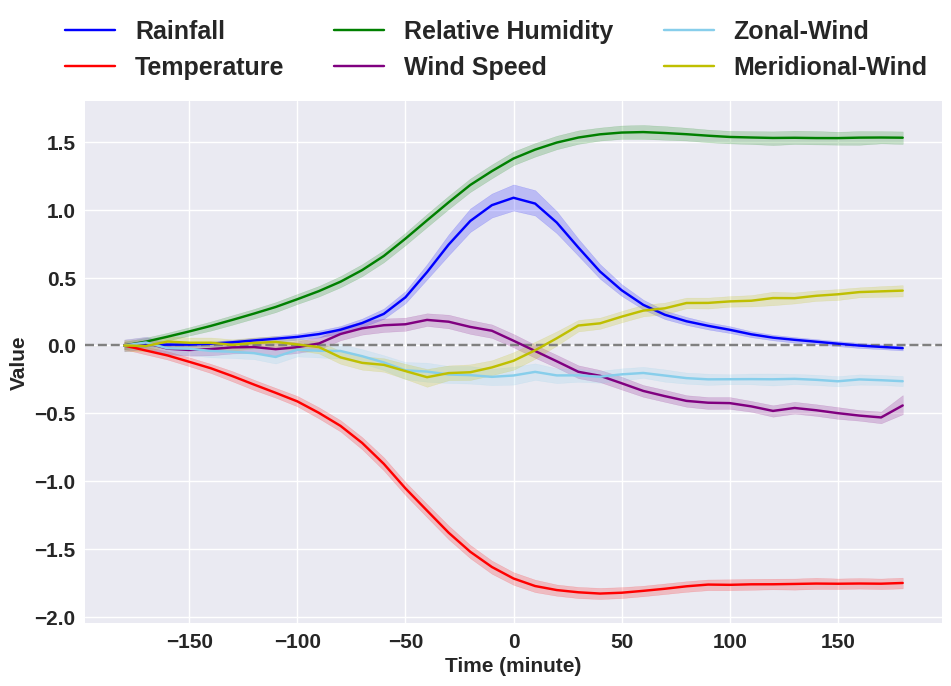

In [7]:
def set_legends(
        ax, handles, labels,
        legend_labels = ["Rainfall", "Temperature", "Relative Humidity", "Wind Speed", "Zonal-Wind", "Meridional-Wind"],
        legend_bbox_to_anchor=(0.48, 1.2)
    ):
    if legend_labels:
        ax.legend(handles, legend_labels, prop={'size': 18, 'weight': 'bold'}, loc='upper center', ncol=3, bbox_to_anchor=legend_bbox_to_anchor)
        return
    plt.legend(prop={'size': 18, 'weight': 'bold'}, loc='upper center', ncol=4, bbox_to_anchor=legend_bbox_to_anchor)

def set_labels(ax):
    fontsize, fontweight = 15, 'bold'
    ax.set_xlabel("Time (minute)", fontsize=fontsize, fontweight=fontweight)
    ax.set_ylabel('Value', fontsize=fontsize, fontweight=fontweight)

def set_ticks(ax, xticks = None, yticks = None, xticklabels = None, yticklabels = None):
    fontsize, fontweight = 15, 'bold'
    if xticks:
        ax.set_xticks(xticks)
    if yticks:
        ax.set_yticks(yticks)
    if xticklabels:
        ax.set_xticklabels(xticklabels)
    if yticklabels:
        ax.set_yticklabels(yticklabels)

    for obj in ax.get_xticklabels():
        obj.set_fontweight(fontweight)
        obj.set_fontsize(fontsize)
    for obj in ax.get_yticklabels():
        obj.set_fontweight(fontweight)
        obj.set_fontsize(fontsize)

def get_palette(target_params, colors = ['blue', 'red', 'green', 'purple', 'skyblue', 'y']):
    return {name: col for name, col in zip(target_params, colors)}

fig, ax = plt.subplots(figsize=(10, 7))
ax.axhline(y=0, linestyle='--', color='gray')
# for station_name, grouped_df in compare_df.groupby(by=["Station_Name"]):
#     if station_name not in exclude_observation_points:
#         sns.lineplot(data=grouped_df, x="Time", y="Value", hue="ParamName", hue_order=target_col, ax=ax)

# exclude_observation_points=["MM-EFCOS_00173456", "CentPark_00181288", "Vlz-DRRMO_00174734", "MM-Libertad_00181289"]
# compare_df = compare_df.loc[~compare_df["Station_Name"].isin([exclude_observation_points])]
target_params = ["Hourly rainfall", "Temperature", "Relative Humidity", "Wind Speed", "U-Wind", "V-Wind"]
# target_params = ["Wind Speed", "U-Wind", "V-Wind"]
# legend_labels = ["Wind Speed", "Zonal-Wind", "Meridional-Wind"]
# colors = ['purple', 'skyblue', 'y']

g = sns.lineplot(data=data_df, x="Time", y="Value", hue="ParamName", hue_order=target_params, ax=ax, ci=95, palette=get_palette(target_params))
# g = sns.lineplot(data=data_df, x="Time", y="Value", hue="ParamName", hue_order=target_params, ax=ax, ci=95, palette=get_palette(target_params, colors))

handles, labels = g.get_legend_handles_labels()

set_legends(ax, handles, labels)
# set_legends(ax, handles, labels, legend_labels)

set_labels(ax)
set_ticks(ax)

plt.tight_layout()
plt.savefig('alldata-epoch-analysis.pdf', format='pdf', bbox_inches='tight')
plt.show()
plt.close()

In [8]:
def format_time(t: str):
    t = t.replace('.csv', '').replace('-', ':')
    if t.endswith(':0'):
        t = t.replace(':0', ':00')
    if len(t.split(':')[0]) == 1:
        t = f'0{t}'
    return t

def get_times(date: str):
    peak_time = df.loc[df.date == date].peak_time.tolist()[0]
    start_time_idx = _timestep_csv_names.index(f'{peak_time}.csv')
    return ['{} UTC'.format(format_time(t)) for t in _timestep_csv_names[start_time_idx - 18: start_time_idx + 19]]

print(get_times('2020-09-14'))

['03:00 UTC', '03:10 UTC', '03:20 UTC', '03:30 UTC', '03:40 UTC', '03:50 UTC', '04:00 UTC', '04:10 UTC', '04:20 UTC', '04:30 UTC', '04:40 UTC', '04:50 UTC', '05:00 UTC', '05:10 UTC', '05:20 UTC', '05:30 UTC', '05:40 UTC', '05:50 UTC', '06:00 UTC', '06:10 UTC', '06:20 UTC', '06:30 UTC', '06:40 UTC', '06:50 UTC', '07:00 UTC', '07:10 UTC', '07:20 UTC', '07:30 UTC', '07:40 UTC', '07:50 UTC', '08:00 UTC', '08:10 UTC', '08:20 UTC', '08:30 UTC', '08:40 UTC', '08:50 UTC', '09:00 UTC']


In [9]:
def get_x_from_utc(target_utc, original_times, utc_times):
    return original_times[utc_times.index(target_utc)]

def set_xlines(ax, labeltext: str, labelx, labely, start = None, end = None):
    if start:
        ax.axvline(x=start, color='gray', linestyle='--')
    ax.text(labelx, labely, labeltext, fontweight='bold', color='black', fontsize=16, transform=ax.transAxes)
    if end:
        ax.axvline(x=end, color='gray', linestyle='--')

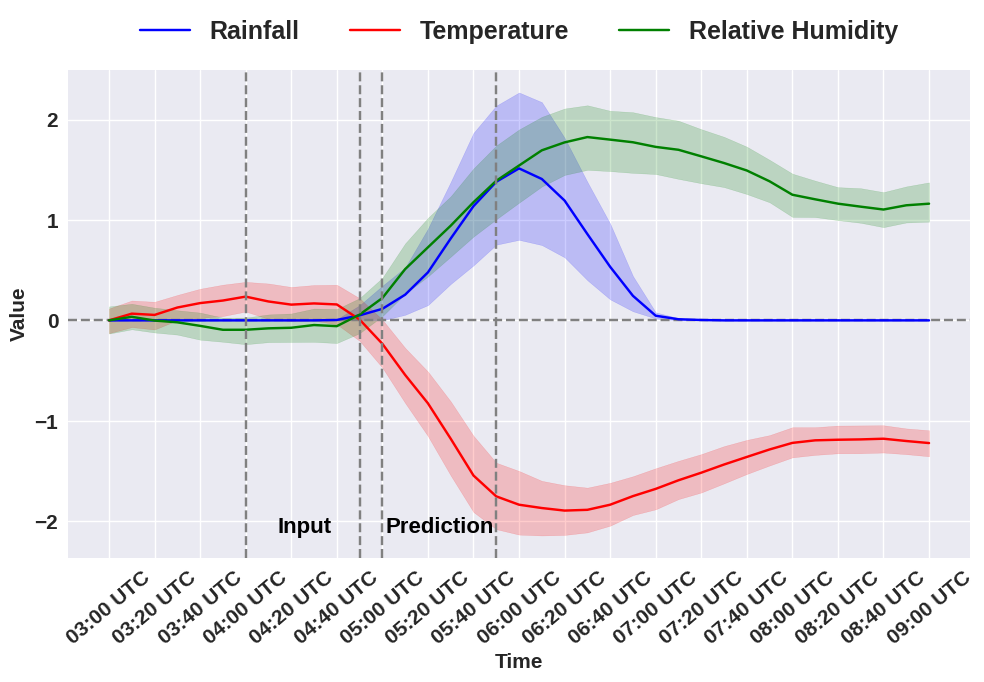

In [10]:
target_params = ["Hourly rainfall", "Temperature", "Relative Humidity"]
target_date = "2020-09-14"

fig, ax = plt.subplots(figsize=(10, 7))
ax.axhline(y=0, linestyle='--', color='gray')
# for station_name, grouped_df in compare_df.groupby(by=["Station_Name"]):
#     if station_name not in exclude_observation_points:
#         sns.lineplot(data=grouped_df, x="Time", y="Value", hue="ParamName", hue_order=target_col, ax=ax)

# exclude_observation_points=["MM-EFCOS_00173456", "CentPark_00181288", "Vlz-DRRMO_00174734", "MM-Libertad_00181289"]
# compare_df = compare_df.loc[~compare_df["Station_Name"].isin([exclude_observation_points])]

target_df = data_df.loc[data_df["date"] == target_date]
g = sns.lineplot(
    data=target_df,
    x="Time",
    y="Value",
    hue="ParamName",
    hue_order=target_params,
    ax=ax,
    palette=get_palette(target_params, ['blue', 'red', 'green'])
)
handles, labels = g.get_legend_handles_labels()
set_legends(ax, handles, labels, legend_labels = ["Rainfall", "Temperature", "Relative Humidity"], legend_bbox_to_anchor=(0.5, 1.15))
set_labels(ax)
ax.set_xlabel('Time')
utc_times = get_times(target_date)
original_times = sorted(target_df.Time.unique().tolist())
set_ticks(ax, xticks=original_times, xticklabels=utc_times)
# set_xlines(
#     ax, labeltext='Input', labelx='04:20 UTC', labely=-1.5,
#     start=original_times[utc_times.index('04:00 UTC')],
#     end=original_times[utc_times.index('04:50 UTC')],
# )
set_xlines(
    ax, labeltext='Input',
    labelx=0.232, labely=0.05,
    start=get_x_from_utc('04:00 UTC', original_times, utc_times),
    end=get_x_from_utc('04:50 UTC', original_times, utc_times),
)
set_xlines(
    ax, labeltext='Prediction',
    labelx=0.352, labely=0.05,
    start=get_x_from_utc('05:00 UTC', original_times, utc_times),
    end=get_x_from_utc('05:50 UTC', original_times, utc_times),
)
ax.set_xticks(ax.get_xticks()[::2])
plt.xticks(rotation=40)
plt.tight_layout()
plt.savefig('20200914-epoch-analysis.pdf', format='pdf', bbox_inches='tight')
plt.show()
plt.close()

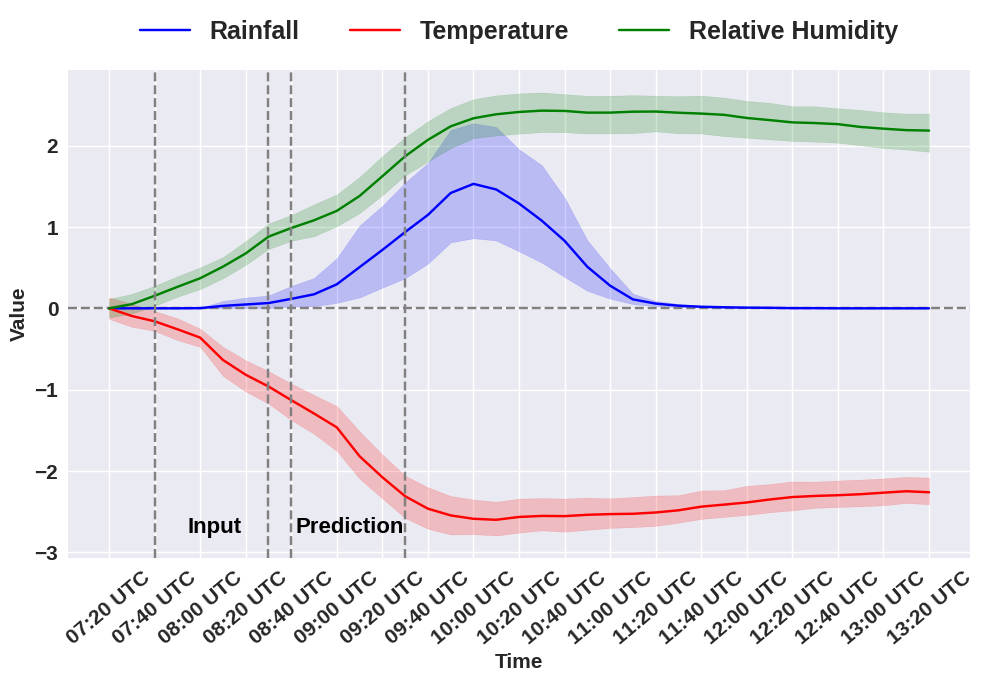

In [12]:
target_params = ["Hourly rainfall", "Temperature", "Relative Humidity"]
target_date = "2019-10-12"

fig, ax = plt.subplots(figsize=(10, 7))
ax.axhline(y=0, linestyle='--', color='gray')
# for station_name, grouped_df in compare_df.groupby(by=["Station_Name"]):
#     if station_name not in exclude_observation_points:
#         sns.lineplot(data=grouped_df, x="Time", y="Value", hue="ParamName", hue_order=target_col, ax=ax)

# exclude_observation_points=["MM-EFCOS_00173456", "CentPark_00181288", "Vlz-DRRMO_00174734", "MM-Libertad_00181289"]
# compare_df = compare_df.loc[~compare_df["Station_Name"].isin([exclude_observation_points])]

target_df = data_df.loc[data_df["date"] == target_date]
g = sns.lineplot(
    data=target_df,
    x="Time",
    y="Value",
    hue="ParamName",
    hue_order=target_params,
    ax=ax,
    palette=get_palette(target_params, ['blue', 'red', 'green'])
)
handles, labels = g.get_legend_handles_labels()
set_legends(ax, handles, labels, legend_labels = ["Rainfall", "Temperature", "Relative Humidity"], legend_bbox_to_anchor=(0.5, 1.15))
set_labels(ax)
ax.set_xlabel('Time')
utc_times = get_times(target_date)
original_times = sorted(target_df.Time.unique().tolist())
set_ticks(ax, xticks=original_times, xticklabels=utc_times)
# set_xlines(
#     ax, labeltext='Input', labelx='04:20 UTC', labely=-1.5,
#     start=original_times[utc_times.index('04:00 UTC')],
#     end=original_times[utc_times.index('04:50 UTC')],
# )
set_xlines(
    ax, labeltext='Input',
    labelx=0.132, labely=0.05,
    start=get_x_from_utc('07:40 UTC', original_times, utc_times),
    end=get_x_from_utc('08:30 UTC', original_times, utc_times),
)
set_xlines(
    ax, labeltext='Prediction',
    labelx=0.252, labely=0.05,
    start=get_x_from_utc('08:40 UTC', original_times, utc_times),
    end=get_x_from_utc('09:30 UTC', original_times, utc_times),
)
ax.set_xticks(ax.get_xticks()[::2])
plt.xticks(rotation=40)
plt.tight_layout()
plt.savefig('20191012-epoch-analysis.pdf', format='pdf', bbox_inches='tight')
plt.show()
plt.close()